# Fanfiction Story Analysis

In this section, we take a sample of 1000 stories from fanfiction.net and break down some of their characteristics. Then using all available data from the site, we try to make predictions on the number of reviews a story is expected to have given select features. These predicted values can be used as benchmarks to see whether stories are overperforming or underperforming relative to their peers.

In [1]:
# imports libraries
import pickle										# import/export lists
import math											# mathematical functions
import datetime										# dates
import re 											# regular expression
import pandas as pd									# dataframes
import numpy as np									# numerical computation
import matplotlib.pyplot as plt						# plot graphics
import seaborn as sns								# graphics supplemental
import statsmodels.formula.api as smf				# statistical models
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor as vif)				# vif

In [2]:
# opens cleaned data
with open ('df_stories', 'rb') as fp:
    df = pickle.load(fp)

In [3]:
# creates subset of data of online stories
df_online = df.loc[df.state == 'online', ].copy()

In [4]:
# sets current year
cyear = datetime.datetime.now().year

## Exploration of data

Let's begin by examining the current state of stories: online, deleted, or missing. Missing stories are stories whose URL has moved due to shifts in the fanfiction achiving system.

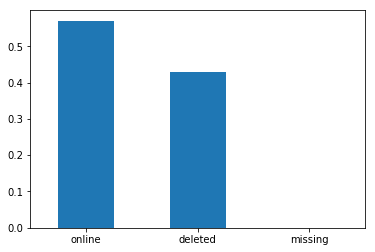

In [5]:
# examines state of stories
state = df['state'].value_counts()

# plots chart
(state/np.sum(state)).plot.bar()
plt.xticks(rotation=0)
plt.show()

Surprisingly, it appears only about ~60% of stories that were once published still remain on the site! This is in stark contrast to user profiles, where less than 0.1% are deleted.

From this, we can only guess that authors actively take stories down, presumably to hide earlier works as their writing abilities improve or to replace them with rewrites. Authors who delete their profiles and stories that were deleted for fanfiction policy violations would also contribute to these figures.

Now let's examine the volume of stories published across time.

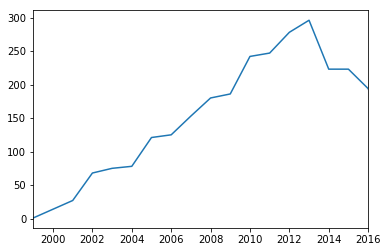

In [7]:
# examines when stories first created
df_online['pub_year'] = [int(row[2]) for row in df_online['published']]
entry = df_online['pub_year'].value_counts().sort_index()

# plots chart
entry.plot()
plt.xlim([np.min(entry.index.values), cyear-1])
plt.show()

We see a large jump starting in the 2010s, peaking around 2013, then a steady decline afterward. Unlike with profiles, you do not see the dips matching the Great Fanfiction Purge of 2002 and 2012.

The decline could be from a variety of factors. One could be competing fanfiction sites.  Most notably, the nonprofit site, Archive of Our Own (AO3), started gaining traction due to its greater inclusivity of works and its tagging system that helps users to filter and search for works.

Another question to ask is if the increasing popularity of fanfiction is fueled by particular fandoms. It is well known in the fanfiction community that fandoms like Star Trek paved the road. Harry Potter and Naruto also held a dominating presence in the 2000s. Later on, we will try to quantify how much each of these fandoms contributed to the volume of fanfiction produced.

### Genres

Now let's look at the distribution across the stories. Note that "General" includes stories that do not have a genre label.

In [8]:
# splits genres
df_online['genre'] = [re.sub('Hurt/Comfort', 'Hurt-Comfort', row)
                      for row in df_online['genre']]
df_online['genre'] = [re.sub(' ', '', row)
                      for row in df_online['genre']]
df_online['genre'] = [re.sub('NA', 'General', row)
                      for row in df_online['genre']]
df_online['genre'] = [row.split('/') for row in df_online['genre']]

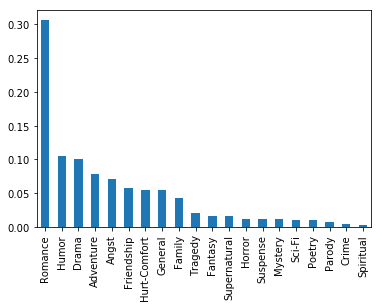

In [9]:
# examines top genres individually
genres_indiv = [item for sublist in df_online['genre'] for item in sublist]
genres_indiv = pd.Series(genres_indiv).value_counts()

# plots chart
(genres_indiv/np.sum(genres_indiv)).plot.bar()
plt.xticks(rotation=90)
plt.show()

Romance takes the lead! In fact, ~30% of the genre labels used is "Romance". In second and third place are Humor and Drama respectively.

The least popular genres appear to be Crime, Horror, and Mystery. 

So far, nothing here deviates much from intuition. We'd expect derivative works to focus more on existing character relationships and/or the canonic world, and less on stand-alone plots and twists. 

What about how the genres combine?

In [10]:
# creates contingency table
gen_pairs = df_online.loc[[len(row) > 1 for row in df_online.genre], 'genre']
gen1 = pd.Series([row[0][:3] for row in gen_pairs] + [row[1][:3] for row in gen_pairs])
gen2 = pd.Series([row[1][:3] for row in gen_pairs] + [row[0][:3] for row in gen_pairs])
cross = pd.crosstab(index=gen1, columns=gen2)

# plots table
cm = sns.light_palette('green', as_cmap=True)
cross.style.background_gradient(cmap=cm)

col_0,Adv,Ang,Cri,Dra,Fam,Fan,Fri,Hor,Hum,Hur,Mys,Par,Poe,Rom,Sci,Spi,Sup,Sus,Tra
row_0,,,,,,,,,,,,,,,,,,,
Adv,0,7,2,27,10,16,26,4,28,1,13,4,0,132,13,1,8,15,3
Ang,7,0,1,44,9,0,8,11,2,31,3,2,11,118,1,0,2,1,18
Cri,2,1,0,2,0,0,3,0,1,1,2,0,0,5,1,0,0,0,2
Dra,27,44,2,0,20,4,12,4,18,13,4,0,5,232,4,2,6,4,15
Fam,10,9,0,20,0,4,17,0,23,32,0,0,1,51,2,0,2,1,3
Fan,16,0,0,4,4,0,5,0,4,1,0,0,0,21,4,2,3,2,1
Fri,26,8,3,12,17,5,0,0,25,35,2,1,0,93,3,2,3,1,2
Hor,4,11,0,4,0,0,0,0,3,2,1,0,2,11,1,1,6,4,2
Hum,28,2,1,18,23,4,25,3,4,1,5,19,1,241,5,0,9,1,2


In terms of how genres cross, romance appears to pair well with everything. Angst pairs with drama and hurt/comfort. Humor and parody go hand in hand.

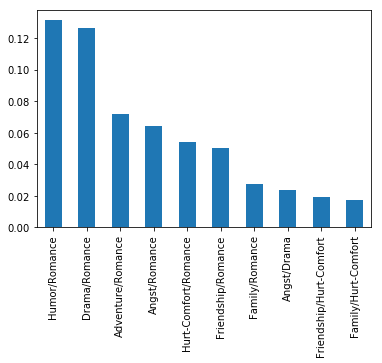

In [20]:
# examines distribution of multigenres
genres_multi = ['/'.join(sorted(row)) for row in df_online['genre'] if len(row) > 1]
genres_multi = pd.Series(genres_multi).value_counts()

# plots chart
(genres_multi[:10]/np.sum(genres_multi)).plot.bar()
plt.xticks(rotation=90)
plt.show()

### Ratings

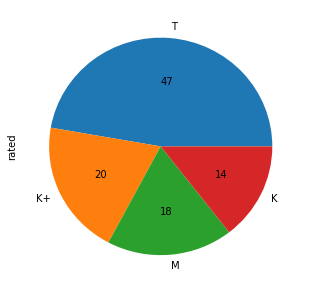

In [8]:
# examines state of stories
rated = df_online['rated'].value_counts()
rated.plot.pie(autopct='%.f', figsize=(5,5))

plt.show()

## Media and fandoms

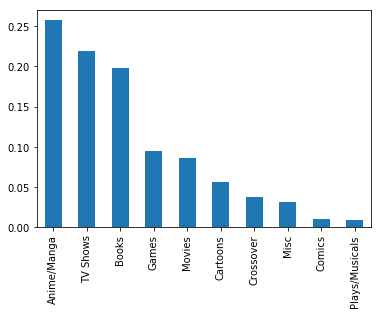

In [9]:
# examines distribution of media
media = df_online['media'].value_counts()
(media/np.sum(media)).plot.bar()
plt.xticks(rotation=90)

plt.show()

Anime/Manga is the most popular media.

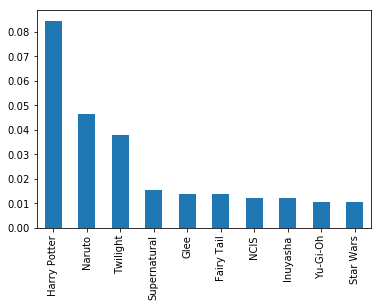

In [10]:
# examines distribution of media
fandom = df_online['fandom'].value_counts()
(fandom[:10]/np.sum(fandom)).plot.bar()
plt.xticks(rotation=90)

plt.show()

The most popular fandom is, unsurprisingly, Harry Potter. However, it still consitutes a much smaller portion of the fanfiction base than initially assumed, at ~8%.

One question we would like to address is what fandoms contributed to the increases in stories over time. However, we will return to that later once we have collected a larger sample size.

## Chapter length and completion status

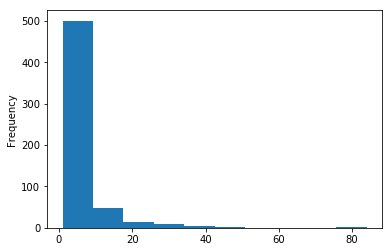

In [11]:
# examines distribution of number of chapters
df_online['chapters'] = df_online['chapters'].fillna(1)
df_online['chapters'].plot.hist()

plt.show()

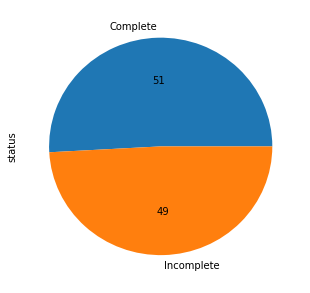

In [12]:
# examines distribution of story status
status = df_online['status'].value_counts()
status.plot.pie(autopct='%.f', figsize=(5,5))

plt.show()

It's about an even split between completed and incompleted stories.

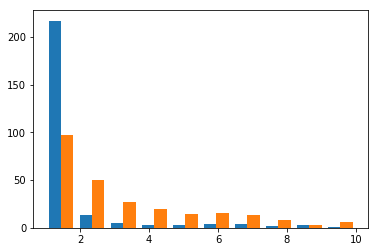

In [13]:
complete = df_online.loc[df_online.status == 'Complete', 'chapters']
incomplete = df_online.loc[df_online.status == 'Incomplete', 'chapters']

plt.hist([complete, incomplete], range=[1,10])

plt.show()

Oneshots explain the large proportion of completed stories.

## Publication timing

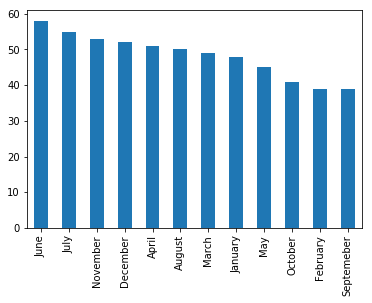

In [96]:
# examines when stories first created
df_online['pub_month'] = [months[int(row[0])] for row in df_online['published']]
month = df_online['pub_month'].value_counts()
month.plot.bar()
plt.xticks(rotation=90)

plt.show()

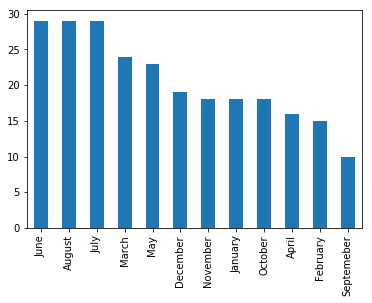

In [104]:
# examines when stories first created
upd_month = [months[int(row[0])] for row in df_online['updated'] if row != 'NA']
upd_month = pd.Series(upd_month).value_counts()
upd_month.plot.bar()
plt.xticks(rotation=90)

plt.show()

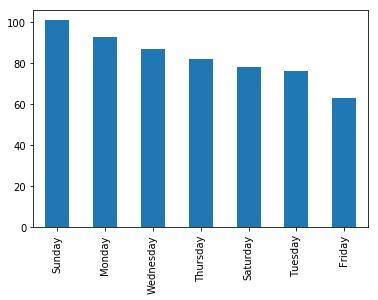

In [110]:
# examines when stories first created
dayofweek = [days[datetime.date(int(row[2]), int(row[0]), int(row[1])).weekday()] 
             for row in df_online['published']]
dayofweek = pd.Series(dayofweek).value_counts()
dayofweek.plot.bar()
plt.xticks(rotation=90)

plt.show()

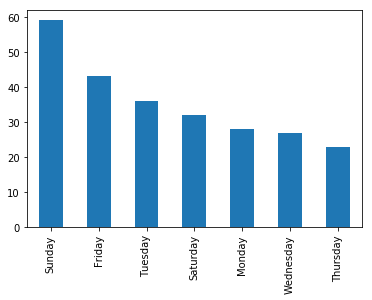

In [111]:
# examines when stories first created
dayofweek = [days[datetime.date(int(row[2]), int(row[0]), int(row[1])).weekday()] 
             for row in df_online['updated'] if row != 'NA']
dayofweek = pd.Series(dayofweek).value_counts()
dayofweek.plot.bar()
plt.xticks(rotation=90)

plt.show()

In [109]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['NA', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 
          'August', 'Septemeber', 'October', 'November', 'December']

# Regression Analysis

In this section, we will try to predict the number of stories an (active) user would write based off the number of years have they been on the site, the number of authors/stories they have favorited, and whether or not they are in a community.

In [14]:
df_online.columns.values

array(['storyid', 'userid', 'title', 'summary', 'media', 'fandom', 'rated',
       'language', 'genre', 'characters', 'chapters', 'words', 'reviews',
       'favs', 'follows', 'updated', 'published', 'status', 'state',
       'pub_year'], dtype=object)

In [15]:
df_online['ratedM'] = [row == 'M' for row in df_online['rated']]

In [87]:
df_online['fansize'] = [fandom[row] for row in df_online['fandom']]

In [115]:
df_online['words1k'] = df_online['words']/1000

In [30]:
df_online['age'] = [cyear - int(row) for row in df_online['pub_year']]

In [132]:
# runs OLS regression
formula = 'reviews ~ chapters + words1k + ratedM + age + fansize'
reg = smf.ols(data=df_online, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                reviews   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     115.5
Date:                Mon, 07 Aug 2017   Prob (F-statistic):           1.67e-82
Time:                        13:15:03   Log-Likelihood:                -2857.5
No. Observations:                 537   AIC:                             5727.
Df Residuals:                     531   BIC:                             5753.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -9.7252      4.480     -2.

In [133]:
# runs OLS regression
formula = 'lnfavs ~ lnwords1k + ratedM + complete + age + fansize'
reg = smf.ols(data=df_online, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnfavs   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     42.66
Date:                Mon, 07 Aug 2017   Prob (F-statistic):           1.36e-36
Time:                        13:16:30   Log-Likelihood:                -745.22
No. Observations:                 505   AIC:                             1502.
Df Residuals:                     499   BIC:                             1528.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.5288      0.117  

In [32]:
# creates copy of only active users
df_active = df_profile.loc[df_profile.status != 'inactive', ].copy()

# creates age variable
df_active['age'] = 17 - pd.to_numeric(df_active['join_year'])
df_active.loc[df_active.age < 0, 'age'] = df_active.loc[df_active.age < 0, 'age'] + 100
df_active = df_active[['st', 'fa', 'fs', 'cc', 'age']]

# turns cc into binary
df_active.loc[df_active['cc'] > 0, 'cc'] = 1

## Multicollinearity

In [33]:
# displays correlation matrix
df_active.corr()

,st,fa,fs,cc,age
st,1.000000,0.089321,0.142494,0.052937,0.170821
fa,0.089321,1.000000,0.706184,0.017645,0.007866
fs,0.142494,0.706184,1.000000,0.118110,0.011833
cc,0.052937,0.017645,0.118110,1.000000,0.113621
age,0.170821,0.007866,0.011833,0.113621,1.000000


In [34]:
# creates design_matrix 
X = df_active
X['intercept'] = 1

# displays variance inflation factor
vif_results = pd.DataFrame()
vif_results['VIF Factor'] = [vif(X.values, i) for i in range(X.shape[1])]
vif_results['features'] = X.columns
vif_results

,VIF Factor,features
0,1.051990,st
1,2.013037,fa
2,2.064973,fs
3,1.036716,cc
4,1.042636,age
5,2.824849,intercept


Results indicate there is some correlation between two of the independent variables: 'fa' and 'fs', implying one of them may not be necessary in the model.

## Nonlinearity

We know from earlier distributions that some of the variables are heavily right-skewed. We created some scatter plots to confirm that the assumption of linearity holds.

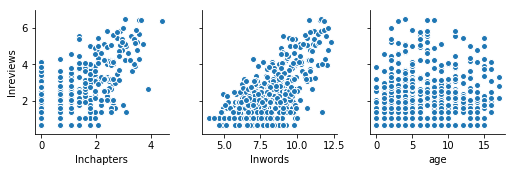

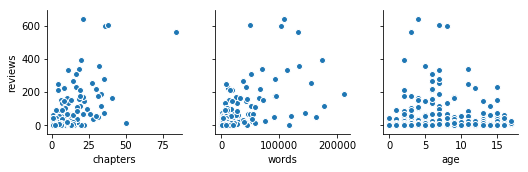

In [122]:
df_online['lnreviews'] = np.log(df_online['reviews']+1)
df_online['lnchapters'] = np.log(df_online['chapters'])
df_online['lnwords1k'] = np.log(df_online['words1k'])

sns.pairplot(data=df_online, y_vars=['lnreviews'], x_vars=['lnchapters', 'lnwords', 'age'])
sns.pairplot(data=df_online, y_vars=['reviews'], x_vars=['chapters', 'words', 'age'])

plt.show()

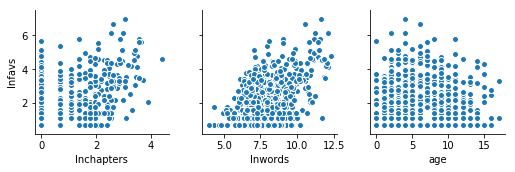

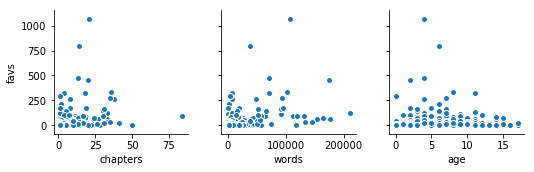

In [123]:
df_online['lnfavs'] = np.log(df_online['favs']+1)

sns.pairplot(data=df_online, y_vars=['lnfavs'], x_vars=['lnchapters', 'lnwords', 'age'])
sns.pairplot(data=df_online, y_vars=['favs'], x_vars=['chapters', 'words', 'age'])

plt.show()

The data is clustered around the zeros. Let's try a log transformation.

## Regression Model

In [47]:
# runs OLS regression
formula = 'st ~ fa + fs + cc + age'
reg = smf.ols(data=df_active, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     61.31
Date:                Thu, 03 Aug 2017   Prob (F-statistic):           2.70e-46
Time:                        18:53:22   Log-Likelihood:                -757.62
No. Observations:                 992   AIC:                             1525.
Df Residuals:                     987   BIC:                             1550.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0338      0.029     -1.171      0.2

The log transformations helped increase the fit from and R-squared of ~0.05 to ~0.20.

From these results, we can see that:

* A 1% change in number of authors favorited is associated with a ~15% change in the number of stories written.
* A 1% change in number of stories favorited is associated with a ~4% change in the number of stories written.
* Being in a community is associated with a ~0.7 increase in the number of stories written.
* One more year on the site is associated with a ~3% change in the number of stories written.

We noted earlier that 'fa' and 'fs' had a correlation of ~0.7. As such, we reran the regression without 'fa' first, then again without 'fs'. The model without 'fs' yielded a better fit (R-squared), as well as AIC and BIC.

In [48]:
# runs OLS regression
formula = 'st ~ fa + cc + age'
reg = smf.ols(data=df_active, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     79.67
Date:                Thu, 03 Aug 2017   Prob (F-statistic):           3.69e-46
Time:                        18:53:27   Log-Likelihood:                -760.24
No. Observations:                 992   AIC:                             1528.
Df Residuals:                     988   BIC:                             1548.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0169      0.028     -0.605      0.5

Without 'fs', we lost some information but not much:

* A 1% change in number of authors favorited is associated with a ~20% change in the number of stories written.
* Being in a community is associated with a ~0.7 increase in the number of stories written.
* One more year on the site is associated with a ~3% change in the number of stories written.

All these results seem to confirm a basic intuition that the more active an user reads (as measured by favoriting authors and stories), the likely it is that user will write more stories. Being longer on the site and being part of a community is also correlated to publications.

To get a sense of the actual magnitude of these effects, let's attempt some plots:

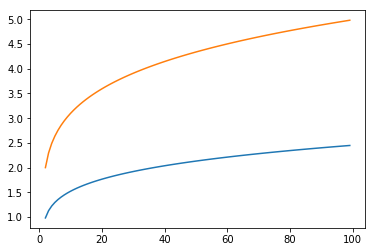

In [99]:
def graph(formula, x_range):  
    y = np.array(x_range)
    x = formula(y)
    plt.plot(y,x)  

graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1)))), 
      range(2,100,1))
graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1))+reg.params[2])), 
      range(2,100,1))

plt.show() 

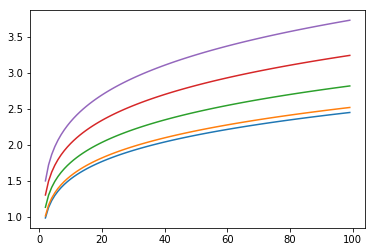

In [98]:
ages = [0, 1, 5, 10, 15]
for age in ages:
    graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1))+reg.params[3]*age)), 
          range(2,100,1))

plt.show() 